In this notebook I will analyze the patents about electrically debondable adhesives form Henkel.

In [1]:
# Imports 

# Own Packages
from Masterarbeit_utils.model_utils_agg import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site Packages
import pandas as pd
import numpy as np
import pickle as pk
import torch
import os 
import sys
import psutil
from collections import Counter
import itertools
# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.fft import fft, fftfreq
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png
from bokeh.palettes import Viridis256, Category20
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.colors import RGB

# Huggingface
from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

2023-11-28 15:14:39.914101: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 15:14:39.936684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 15:14:40.383421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(len(fterms_orbit_agg), len(set(fterms_orbit_agg)), len(set([f[:5] for f in fterms_orbit_agg])), len(set(fterms_orbit)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 print(len(fterms_orbit_agg), len(set(fterms_orbit_agg)), len(set([f[:5] for f in fterms_     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'fterms_orbit_agg' is not defined

In [2]:
###########################################################
# Loading the Henkel Patents
###########################################################

# Directories in which data important for the notebook is stored
dump_dir = 'PK_DUMP'
data_dir = 'data'

# Loading the dataframes with the patents deemed most important for electrically debondable adhesives from Henkel
henkel_patents = pd.read_csv(f'{data_dir}/Henkel_patente_patstat_docdb_families_abstract.csv', delimiter=',').reset_index(drop=True)
henkel_orbit = pd.read_csv(f'{data_dir}/Henkel_Orbit_Suche_Patstat_Export.csv', delimiter=',')



# Filtering the Samples which contain F-Terms
henkel_filtered = henkel_patents[henkel_patents['fterms'].notna()]
henkel_filtered = henkel_filtered.reset_index(drop=True)

orbit_filtered = henkel_orbit[henkel_orbit['fterms'].notna()]
orbit_filtered = orbit_filtered.reset_index(drop=True)

print(f"There are {len(henkel_patents['doc_db_family_id'].unique())} unique patents in the Henkel dataset, only {len(henkel_filtered['doc_db_family_id'].unique())} of them contain F-Terms.")
print(f"There are {len(henkel_orbit)} patents in the Henkel orbit")

# extracting all f-terms form the datasets
fterms_henkel = [fterm[:10] for fterms in henkel_filtered['fterms'] for fterm in fterms.split(',')]
fterms_orbit = [fterm[:10] for fterms in orbit_filtered['fterms'] for fterm in fterms.split(',')]

# Aggreagting the F-Terms
with open(f'{dump_dir}/aggregation_dict_new.pk', 'rb') as f:
    aggregation_dict = pk.load(f)

def aggregate(f_term):
    try:
        return aggregation_dict[f_term]
    except KeyError:
        pass

fterms_henkel_agg = [aggregate(fterm) for fterm in fterms_henkel if aggregate(fterm) is not None]
fterms_orbit_agg = [aggregate(fterm) for fterm in fterms_orbit if aggregate(fterm) is not None]

# Counting the occurrences of the henkel and orbit fterms
counter_henkel = Counter(fterms_henkel_agg)
counter_orbit = Counter(fterms_orbit_agg)

# Structuring the henkel F-Terms
henkel_dict = {}
for fterm in counter_henkel.keys():
    theme = fterm[:5]
    try:
        _ = henkel_dict[theme]
    except KeyError:
        henkel_dict[theme] = {}

    vp = fterm[:8]
    try: 
        henkel_dict[theme][vp].append(fterm)
    except KeyError:
        henkel_dict[theme][vp] = [fterm]


################################################################
# Loading the Model
################################################################

model_name = 'gal_1300_new_1'
checkpoint = 86515
# If True normalization is applied to the embeddings
norm = True
context_less = False

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
if model_name.split('_')[1] == '125':
    base_model_name = 'mini'
elif model_name.split('_')[1] == '1300':
    base_model_name = 'base'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cpu'

# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms:,} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/agg_themes_descriptions_new.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/agg_viewpoints_descriptions_new.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/agg_numbers_descriptions_new.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/agg_full_descriptions_new.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb{checkpoint}.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(len([1 for _ in model.parameters()]))]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer

# Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)

if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:
out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
ft_emb_dict = {key: np.abs(fft(value)) for key, value in out_emb_dict.items()}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if context_less:
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

# Extracting the emb_dim
for e in out_emb_dict.values():
    break
emb_dim = e.shape[-1]
print('Embedding Dimension: ', emb_dim)

There are 34 unique patents in the Henkel dataset, only 15 of them contain F-Terms.
There are 37974 patents in the Henkel orbit
Loaded Tokenizer from serialized instance!
There are 195,565 different F-Terms in the whole Dataset!
Embedding Dimension:  2048


In [ ]:
len(theme_dict)

# Plotting the Henkel F-Terms

In [ ]:
###########################################
# Create a histogram of the Henkel F-Terms
###########################################

# Extracting the frequencies and the fterms from the counters
hist = list(counter_henkel.values())
fterms = list(counter_henkel.keys())
print('Number of unique F-terms', len(set(fterms)))

# Sorting the frequencies and the fterms 
idx = np.argsort(hist)[::-1]
hist = [hist[i] for i in idx]
fterms = [fterms[i] for i in idx]
edges = np.arange(len(hist)+1)

# Extracting the theme viewpoint and number definitions

themes = []
for fterm in fterms:
    try:
        themes.append(theme_dict[fterm[:5]]) 
    except KeyError:
        themes.append('Not Found')

vps = []
for fterm in fterms:
    try: 
        vps.append(viewpoint_dict[fterm[:8]])
    except KeyError:
        vps.append('Not Found')
        
numbers = []
for fterm in fterms:
    try:
        numbers.append(number_dict[fterm[:10]]) 
    except KeyError:
        numbers.append('Not Found')

# Create a Bokeh figure
output_notebook()  # Display Bokeh plots in Jupyter Notebook
p = figure(title="Histogram Henkel F-Terms", y_axis_label="Frequency", width=1000, height=1000)

# Create a ColumnDataSource for the histogram bars
source = ColumnDataSource(data={"top": hist, "left": edges[:-1], "right": edges[1:], "theme": themes})

# Create a color mapping for themes
unique_themes = list(set(themes))
color_mapping = factor_cmap("theme", palette=Category20[len(unique_themes)], factors=unique_themes)

# Create VBar glyph for the histogram bars with the color mapping
p.vbar(x="left", top="top", bottom=0, width=1, source=source, fill_color=color_mapping, legend_field="theme")

# Create a new column in the ColumnDataSource for text annotations
text_annotations = [str(count) for count in hist]

# Add annotations to each bin at the correct position
source.add(text_annotations, "text")
source.add(fterms, 'F-Term')
source.add(themes, 'Theme')
source.add(vps, 'Vp.')
source.add(numbers, 'Number')

# Create a HoverTool to display annotations on hover
hover = HoverTool()
hover.tooltips = [("Count", "@text"),("F-Term", "@{F-Term}"), ("Theme", "@Theme"), ("Viewpoint", "@{Vp.}"), ("Number", "@Number")]
p.add_tools(hover)

# Remove x-axis ticks and description
p.xaxis.visible = False

# Show the plot
show(p)


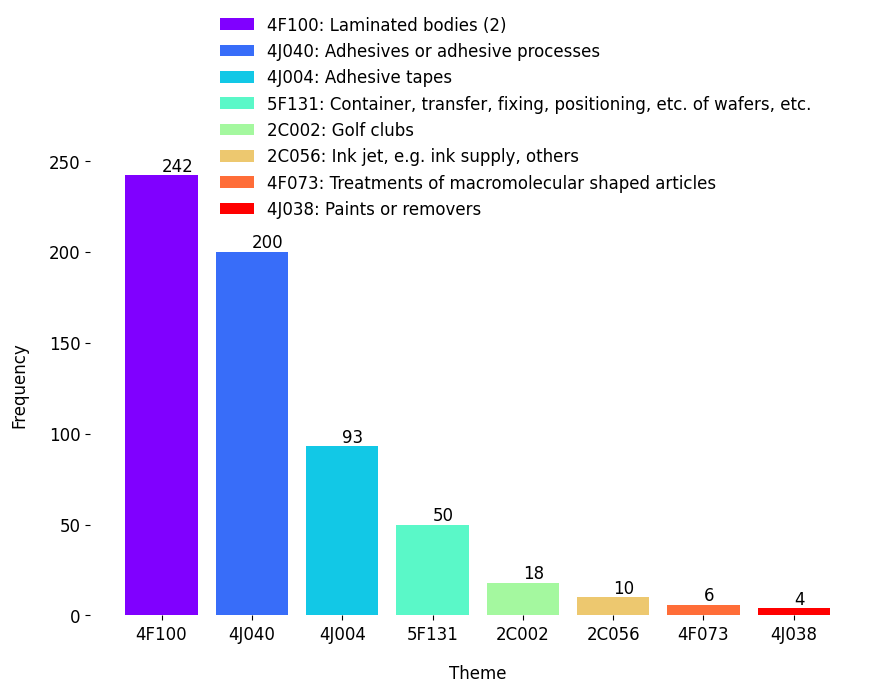

In [28]:
import matplotlib.pyplot as plt

# Plotting the Henkel themes

themes_henkel = [ft[:5] for ft in fterms_henkel_agg]
themes_counter = Counter(themes_henkel)

plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 12

# Sorting themes by frequency in descending order
sorted_themes = sorted(themes_counter.items(), key=lambda x: x[1], reverse=True)
themes = [theme[0] for theme in sorted_themes]
frequencies = [theme[1] for theme in sorted_themes]

# Assigning unique colors to each theme
colors = plt.cm.rainbow(np.linspace(0, 1, len(themes)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(themes, frequencies, color=colors)

# Removing the box and gridlines
plt.box(False)
plt.grid(False)

# Adjusting the x-axis labels
plt.xticks(themes, themes, rotation='horizontal')
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('Theme', labelpad=15)
# Adding annotations for frequencies
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # Frequency

# Creating a custom legend with theme definitions

legend_labels = [f'{key}: {theme_dict[key][0].upper() + theme_dict[key][1:]}' for key in themes]
plt.legend(bars, legend_labels, loc='upper right', frameon=False, bbox_to_anchor=(0.95, 1.33))

# Displaying the plot
plt.savefig('themes_plot.svg', format='svg', bbox_inches='tight')
plt.show()


In [ ]:
# Plotting the Henkel Embeddings and the Orbit Embeddings in TSNE Plots 
orbit_emb = []
o_ft = []
for fterm in counter_orbit.keys(): 
    try:
        orbit_emb.append(out_emb_dict[fterm])
        o_ft.append(fterm)
    except KeyError:
        pass

orbit_emb = np.array(orbit_emb)

henkel_emb = []
h_ft = []
for fterm in counter_henkel.keys():
    try:
        henkel_emb.append(out_emb_dict[fterm])
        h_ft.append(fterm)
    except KeyError:
        pass

henkel_emb = np.array(henkel_emb)

all_emb = np.concatenate([orbit_emb, henkel_emb], 0)
all_ft = [*o_ft, *h_ft]

tsne = TSNE(n_components=2, verbose=0, random_state=69)
rep = tsne.fit_transform(all_emb)

datasource_henkel = ColumnDataSource(
        data=dict(
            x = rep[len(o_ft):,0],
            y = rep[len(o_ft):,1],
            fterms = h_ft,
            themes = [theme_dict[fterm[:5]] for fterm in h_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in h_ft],
            numbers = [number_dict[fterm[:10]] for fterm in h_ft]))

datasource_orbit = ColumnDataSource(
        data=dict(
            x = rep[:len(o_ft), 0],
            y = rep[:len(o_ft), 1],
            fterms = o_ft,
            themes = [theme_dict[fterm[:5]] for fterm in o_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in o_ft],
            numbers = [number_dict[fterm[:10]] for fterm in o_ft]))


hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>F-Term:</b> @fterms<br><b>Theme:</b> @themes<br><b>Viewpoint:</b> @viewpoints<br><b>Number:</b> @numbers</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Henkel and Orbit Embeddings')
    
plot_tsne.circle('x', 'y', size=10, fill_color=RGB(250, 50, 100), alpha=1, line_width=0, source=datasource_henkel, name="Henkel Embeddings")
plot_tsne.square('x', 'y', size=7, fill_color=RGB(50, 75, 250), alpha=0.2, line_width=0, source=datasource_orbit, name="Orbit Embeddings")

show(plot_tsne)

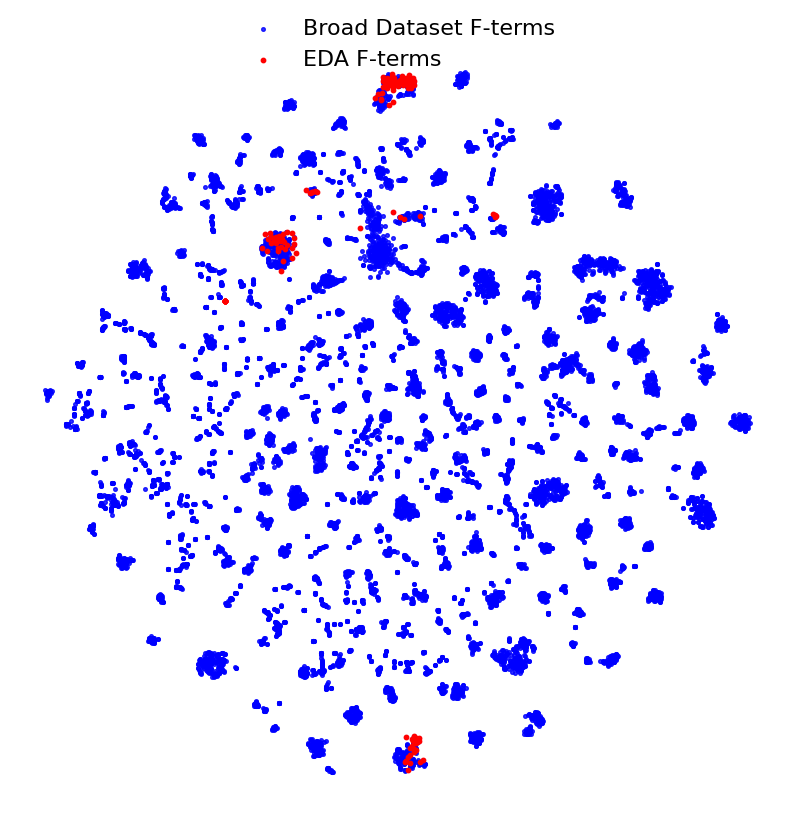

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16


# Assuming out_emb_dict, counter_orbit, counter_henkel, and other necessary variables are already defined

# Prepare Orbit Embeddings
orbit_emb = [out_emb_dict[fterm] for fterm in counter_orbit if fterm in out_emb_dict]
orbit_emb = np.array(orbit_emb)

# Prepare Henkel Embeddings
henkel_emb = [out_emb_dict[fterm] for fterm in counter_henkel if fterm in out_emb_dict]
henkel_emb = np.array(henkel_emb)

# Combine embeddings
all_emb = np.concatenate([orbit_emb, henkel_emb], axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, verbose=0, random_state=69)
rep = tsne.fit_transform(all_emb)

# Split the transformed data
orbit_tsne = rep[:len(orbit_emb)]
henkel_tsne = rep[len(orbit_emb):]

# Create the plot using Matplotlib
plt.figure(figsize=(10, 10))

# Plot Henkel and Orbit Embeddings
plt.scatter(orbit_tsne[:, 0], orbit_tsne[:, 1], color='blue', alpha=0.8, s=7, label='Broad Dataset F-terms')
plt.scatter(henkel_tsne[:, 0], henkel_tsne[:, 1], color='red', alpha=1, s=10, label='EDA F-terms')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), frameon=False)

# Remove axes and grid
plt.axis('off')


# Save the plot as a PNG file
plt.savefig('henkel_orbit_embeddings.svg', format='svg', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
print(f'''
There are 7 main clusters of Henkel F-Terms, which correspont to 7 main Themes:
    "Containers, tranfer, fixing, positioning etc. of wavers ,etc."
    "Adhesives or adhesive processes"
    "Laminated bodies #2"
    "Treatments of macromolecular shaped articles"
    "Paints or removers"
    "ink jet, e.g. ink supply, others"
    "golf clubs"''')

# Simply Searching for Similar F-Term Embeddings

In [30]:
"Searching for similar F-Terms without creating difference Vectors"

# n = number of similar and novel F-Terms (not jet found by previous similarity search), That are saved for each sample. 
n = 50
hits = []
cos = torch.nn.CosineSimilarity(dim=1)

target_themes = ['4F100', '4J040']

for i, q_fterm in enumerate(counter_henkel.keys()):
    if q_fterm[:5] not in target_themes:
        continue
    print(i, q_fterm, end='\r')
    
    q_emb = out_emb_dict[q_fterm]
    search_embs = []
    search_fterms = []
    for fterm, emb in out_emb_dict.items():
        # Filtering all previously found f
        if fterm in hits:
            continue
        if fterm in counter_henkel.keys():
            continue
        search_embs.append(emb)
        search_fterms.append(fterm)

    search_emb = torch.tensor(np.array(search_embs))
    q_emb = torch.tensor(np.array([q_emb for _ in search_emb]))

    simis = cos(search_emb, q_emb)
    idx = np.argsort(simis)
    for i in idx[-n:]:
        hits.append(search_fterms[i])

In [ ]:
# Plotting the embeddigns hits vs the orbit search results

hits_emb = torch.tensor(np.array([out_emb_dict[fterm] for fterm in hits]))

orbit_emb = []
o_ft = []
for fterm in counter_orbit.keys(): 
    try:
        orbit_emb.append(out_emb_dict[fterm])
        o_ft.append(fterm)
    except KeyError:
        pass

orbit_emb = np.array(orbit_emb)

henkel_emb = []
h_ft = []
for fterm in counter_henkel.keys():
    if fterm[:5] in target_themes:
        try:
            henkel_emb.append(out_emb_dict[fterm])
            h_ft.append(fterm)
        except KeyError:
            pass

henkel_emb = np.array(henkel_emb)

all_emb = np.concatenate([orbit_emb, henkel_emb, hits_emb], 0)
all_ft = [*o_ft, *h_ft, *hits]

tsne = TSNE(n_components=2, verbose=0, random_state=69)
rep = tsne.fit_transform(all_emb)

datasource_henkel = ColumnDataSource(
        data=dict(
            x = rep[len(o_ft):len(o_ft) + len(h_ft),0],
            y = rep[len(o_ft):len(o_ft) + len(h_ft),1],
            fterms = h_ft,
            themes = [theme_dict[fterm[:5]] for fterm in h_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in h_ft],
            numbers = [number_dict[fterm[:10]] for fterm in h_ft]))

datasource_orbit = ColumnDataSource(
        data=dict(
            x = rep[:len(o_ft), 0],
            y = rep[:len(o_ft), 1],
            fterms = o_ft,
            themes = [theme_dict[fterm[:5]] for fterm in o_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in o_ft],
            numbers = [number_dict[fterm[:10]] for fterm in o_ft]))

datasource_emb_search = ColumnDataSource(
        data=dict(
            x = rep[len(o_ft) + len(h_ft):, 0],
            y = rep[len(o_ft) + len(h_ft):, 1],
            fterms = hits,
            themes = [theme_dict[fterm[:5]] for fterm in hits],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in hits],
            numbers = [number_dict[fterm[:10]] for fterm in hits]))


hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>F-Term:</b> @fterms<br><b>Theme:</b> @themes<br><b>Viewpoint:</b> @viewpoints<br><b>Number:</b> @numbers</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Henkel and Orbit Embeddings')
    
plot_tsne.circle('x', 'y', size=10, fill_color=RGB(250, 50, 75), alpha=1, line_width=0, source=datasource_henkel, name="Henkel Embeddings")
plot_tsne.square('x', 'y', size=7, fill_color=RGB(50, 75, 250), alpha=0.2, line_width=0, source=datasource_orbit, name="Orbit Embeddings")
plot_tsne.triangle('x', 'y', size=7, fill_color=RGB(75, 250, 50), alpha=0.2, line_width=0, source=datasource_emb_search, name="Cos Similar Embeddings")

show(plot_tsne)

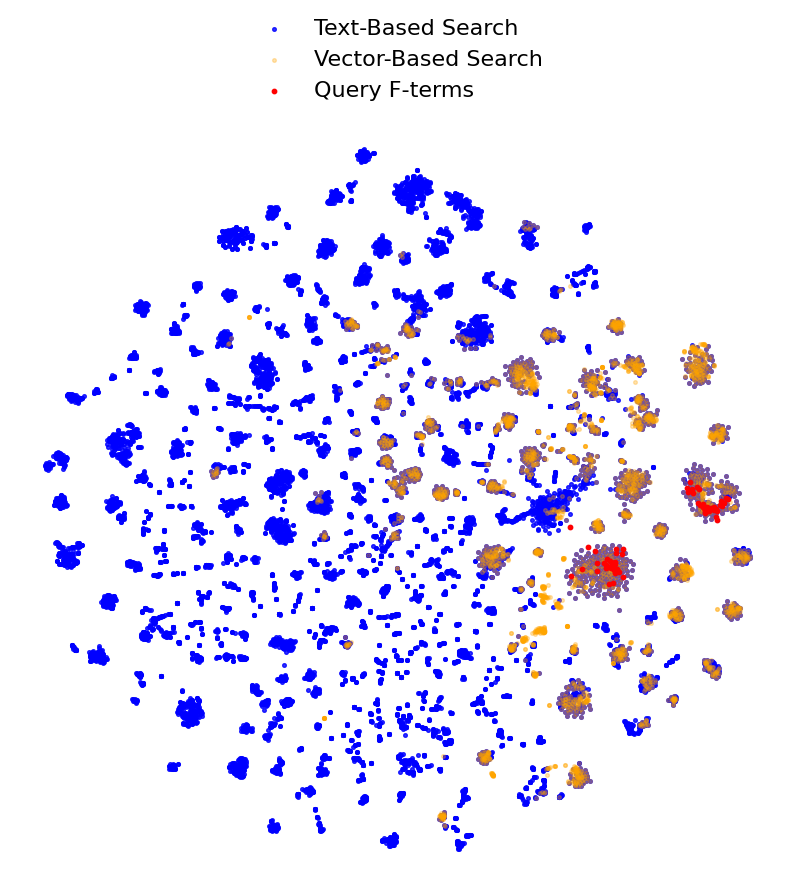

In [35]:
# Assuming your data preparation code remains the same
import matplotlib.pyplot as plt

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

hits_emb = torch.tensor(np.array([out_emb_dict[fterm] for fterm in hits]))

orbit_emb = []
o_ft = []
for fterm in counter_orbit.keys(): 
    try:
        orbit_emb.append(out_emb_dict[fterm])
        o_ft.append(fterm)
    except KeyError:
        pass

orbit_emb = np.array(orbit_emb)

henkel_emb = []
h_ft = []
for fterm in counter_henkel.keys():
    if fterm[:5] in target_themes:
        try:
            henkel_emb.append(out_emb_dict[fterm])
            h_ft.append(fterm)
        except KeyError:
            pass


henkel_emb = np.array(henkel_emb)

all_emb = np.concatenate([orbit_emb, henkel_emb, hits_emb], 0)
all_ft = [*o_ft, *h_ft, *hits]
# Calculate the t-SNE representation
tsne = TSNE(n_components=2, verbose=0, random_state=69)
rep = tsne.fit_transform(all_emb)

# Extracting coordinates for each group
x_henkel = rep[len(o_ft):len(o_ft) + len(h_ft),0]
y_henkel = rep[len(o_ft):len(o_ft) + len(h_ft),1]
x_orbit = rep[:len(o_ft), 0]
y_orbit = rep[:len(o_ft), 1]
x_emb_search = rep[len(o_ft) + len(h_ft):, 0]
y_emb_search = rep[len(o_ft) + len(h_ft):, 1]

# Plotting
plt.figure(figsize=(10, 10))

plt.scatter(x_orbit, y_orbit, color='blue', alpha=0.8, s=7, label='Text-Based Search') # Orbit embeddings
plt.scatter(x_emb_search, y_emb_search, color='orange', alpha=0.3, s=7, label='Vector-Based Search') # Cos Similar embeddings
plt.scatter(x_henkel, y_henkel, color='red', label='Query F-terms', alpha=1, s=10) # Henkel embeddings
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False)

# Removing titles and axis labels
plt.axis('off')

# Saving and showing the plot
plt.savefig('embeddings_visualization.svg', bbox_inches='tight', format='svg')
plt.show()

In [21]:
hits_themes = set([f[:5] for f in hits])
o_themes = set([f[:5] for f in o_ft])

len(hits_themes), len([f for f in hits_themes if f in o_themes])

(160, 117)

# In Viewpoint Differences

In [ ]:
def create_fterm_dict():
    """
    Creates a hirachical dict with all F-Terms ordered by Theme -> Viewpoint > F-Terms
    """
    f_term_dict = {}
    for f_term in f_term_tokens:
        theme = f_term.split('/')[0]
        vp = f_term[:8]
        # Creating a dict entry for the theme
        try: 
            _ = f_term_dict[theme]
        except KeyError:
            f_term_dict[theme] = {}
    
        # Creating a dict entry for the viewpoint
    
        try:
            # The first dict call will def. work the second may work if the vp-dict entry 
            # was already made. If it works the theme is appended to the viewpoint dict
            f_term_dict[theme][vp].append(f_term)
        except KeyError:
            f_term_dict[theme][vp] = []

    return f_term_dict
    

def create_all_diffs():
    """
    Creates all possible in viewpoint combinations and returns them a s a 
    """
    all_diffs = {}
    emb = out_emb_dict
    # Calculating the needed combinations
    f_term_dict = create_fterm_dict()
    for i, (theme, t_dict) in enumerate(f_term_dict.items()):
        # print(i, theme, len(t_dict), end='\r')
        all_diffs[theme] = {}
        for viewpoint, fterms in t_dict.items():
            all_diffs[theme][viewpoint] = {}
            combinations = itertools.combinations(fterms, 2)
            for fterm1, fterm2 in combinations:
                diff = emb[fterm2[:10]] - emb[fterm1[:10]]
                diff = normalize(np.array([diff]))
                all_diffs[theme][viewpoint][(fterm1, fterm2)] = diff

    return all_diffs
    

def create_diffs_tensor(block_theme, all_diffs):
    """
    Creates a tensor with all diffs, which do not contain the block theme.
    Additionaly also returns a list with all comination descriptions
    """
    # Filtering out the unwanted theme
    diffs = {theme: t_dict for theme, t_dict in all_diffs.items() if theme != block_theme}
    out_diffs = []
    out_desc = []
    for _, t_dict in diffs.items():
        for _, vp_dict in t_dict.items():
            for comb, diff in vp_dict.items():
                out_desc.append(comb)
                out_diffs.append(diff)

    out_diffs = np.array(out_diffs)
    out_diffs = out_diffs.squeeze(1)
    return out_diffs, out_desc


def search_cos(query_vec, all_vecs, all_desc, n):
    """
    Computes the cosine similarities between all_vecs and the query_vec and returns the descriptions of the n best matches.
    
    """
    cos = torch.nn.CosineSimilarity(dim=1)
    # Creating an array of query vectors, with the same number of vectors as the all_vecs array.
    query = np.concatenate([query_vec for _ in all_vecs], 0)
    simis = cos(torch.tensor(all_vecs, requires_grad=False), torch.tensor(query, requires_grad=False))
    # Creating the indices of the top n similarities
    idx = np.argsort(simis).numpy()[::-1][:n]
    matches = [all_desc[i] for i in idx]
    simis = [simis[i] for i in idx]
    return matches
    

In [ ]:
# Hirachical dict which contains all in viewpoint differences
all_diffs = create_all_diffs()

In [ ]:
########################################################
# Searching with henkel in viewpoint differences
########################################################

# maximum number of new patents added to the results per query diff
n = 50
# Hirachical dict containing all Henkel f-terms
henkel_dict = {}

for fterm in counter_henkel.keys():
    theme = fterm[:5]
    try:
        _ = henkel_dict[theme]
    except KeyError:
        henkel_dict[theme] = {}

    vp = fterm[:8]
    try: 
        henkel_dict[theme][vp].append(fterm)
    except KeyError:
        henkel_dict[theme][vp] = [fterm]

# List of all henkel f-term in viewpoint combinations 
henkel_invp = []
henkel_invp_diff = []

for t_dict in henkel_dict.values():
    for fterms in t_dict.values():
        combinations = list(itertools.combinations(fterms, 2))
        henkel_invp.extend(combinations)
        for fterm1, fterm2 in combinations:
            diff = normalize(np.array([out_emb_dict[fterm2]])-np.array([out_emb_dict[fterm1]]))
            henkel_invp_diff.append(diff)


found_f_terms = []
# list which stores the query diffs, by which the found_f_terms were found
found_by = []
for i, (query_diff, desc) in enumerate(zip(henkel_invp_diff, henkel_invp)):
    print(i, len(found_f_terms), len(found_by), end='\r')
    f_terms_added = 0
    theme = desc[0][:5]
    search_diffs, search_descs = create_diffs_tensor(theme, all_diffs)
    results = search_cos(query_diff, search_diffs, search_descs, n*10) # Getting more results to account for multiple finings of one f-term
    while f_terms_added < n:
        try:
            fterm1, fterm2 = results.pop(0)
            if fterm1 not in found_f_terms:
                found_f_terms.append(fterm1)
                found_by.append(desc)
                f_terms_added += 1
    
            if fterm2 not in found_f_terms:
                found_f_terms.append(fterm2)
                found_by.append(desc)
                f_terms_added += 1
        except IndexError:
            results = search_cos(query_diff, search_diffs, search_descs, n*1000)

    

In [ ]:
###############################################
# Plotting the in viewpoint search results
###############################################

hits_emb = torch.tensor(np.array([out_emb_dict[fterm[:10]] for fterm in found_f_terms]))
# To compare to a random sample of F-Terms
#random_fterms = np.random.choice(f_term_tokens, len(found_f_terms), replace=False)
#hits_emb = torch.tensor(np.array([out_emb_dict[fterm[:10]] for fterm in random_fterms]))

orbit_emb = []
o_ft = []
for fterm in counter_orbit.keys(): 
    try:
        orbit_emb.append(out_emb_dict[fterm])
        o_ft.append(fterm)
    except KeyError:
        pass

orbit_emb = np.array(orbit_emb)

henkel_emb = []
h_ft = []
for fterm in counter_henkel.keys():
    try:
        henkel_emb.append(out_emb_dict[fterm])
        h_ft.append(fterm)
    except KeyError:
        pass

henkel_emb = np.array(henkel_emb)

all_emb = np.concatenate([orbit_emb, henkel_emb, hits_emb], 0)

tsne = TSNE(n_components=2, verbose=0, random_state=69)
rep = tsne.fit_transform(all_emb)

datasource_henkel = ColumnDataSource(
        data=dict(
            x = rep[len(o_ft):len(o_ft) + len(h_ft),0],
            y = rep[len(o_ft):len(o_ft) + len(h_ft),1],
            fterms = h_ft,
            themes = [theme_dict[fterm[:5]] for fterm in h_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in h_ft],
            numbers = [number_dict[fterm[:10]] for fterm in h_ft]))

datasource_orbit = ColumnDataSource(
        data=dict(
            x = rep[:len(o_ft), 0],
            y = rep[:len(o_ft), 1],
            fterms = o_ft,
            themes = [theme_dict[fterm[:5]] for fterm in o_ft],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in o_ft],
            numbers = [number_dict[fterm[:10]] for fterm in o_ft]))

datasource_emb_search = ColumnDataSource(
        data=dict(
            x = rep[len(o_ft) + len(h_ft):, 0],
            y = rep[len(o_ft) + len(h_ft):, 1],
            fterms = found_f_terms,
            themes = [theme_dict[fterm[:5]] for fterm in found_f_terms],
            viewpoints = [viewpoint_dict[fterm[:8]] for fterm in found_f_terms],
            numbers = [number_dict[fterm[:10]] for fterm in found_f_terms], 
            found_by = [number_dict[comb[0][:10]] +'---' + number_dict[comb[1][:10]] for comb in found_by]))


hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>F-Term:</b> @fterms<br><b>Theme:</b> @themes<br><b>Viewpoint:</b> @viewpoints<br><b>Number:</b> @numbers<br><b>Query:</b> @found_by</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Henkel and Orbit Embeddings')
    
plot_tsne.circle('x', 'y', size=10, fill_color=RGB(250, 50, 75), alpha=1, line_width=0, source=datasource_henkel, name="Henkel Embeddings")
plot_tsne.square('x', 'y', size=7, fill_color=RGB(50, 75, 250), alpha=0.2, line_width=0, source=datasource_orbit, name="Orbit Embeddings")
plot_tsne.triangle('x', 'y', size=7, fill_color=RGB(75, 250, 50), alpha=0.2, line_width=0, source=datasource_emb_search, name="Cos Similar Embeddings")

show(plot_tsne)
    